In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [4]:
from scipy.io import loadmat
import torch
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data = loadmat('/content/drive/MyDrive/Projects/Data/DeepDenoise/spectraw.mat')

In [ ]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'spectraw'])

In [6]:
global dev
dev=torch.device('cpu')

Load denoising model

In [19]:
model_checkpoint = torch.load('/content/drive/MyDrive/Projects/Data/DeepDenoise/DnCNN_absoluteF_rescalednoise3.pth',map_location=dev)
state_dict = model_checkpoint['model_state_dict']

Then we reshape the data to a format compatible with the model imput

In [8]:
test_data = torch.tensor(data['spectraw'], dtype=float, device=dev)

In [9]:
def reformat_data(data,window,SampRate=5):
  """Function used to reformat the data according to the denoising model input"""
  window_sample = np.round(window*0.8)
  times = torch.arange(window*SampRate,len(data)-window*SampRate,window_sample*SampRate*2,dtype=int)
  datar = torch.zeros((times.shape[0]-1,1,2*window*SampRate+1,data.shape[1]),device=dev)
  mean_data = torch.zeros((times.shape[0],data.shape[1]))
  last_sample = torch.zeros((1,1,len(data)-(times[-1]-int(window*SampRate)),data.shape[1]),device=dev)

  for i,t in enumerate(times[:-1]):
    #print(datar[i,0,:,:].shape,data[t-window*SampRate:t+window*SampRate].unsqueeze(0).unsqueeze(0).shape)
    data_seg = data[t-window*SampRate:t+window*SampRate+1,:]
    #mean_data[i,:] = torch.mean(data_seg,dim=0)
    #datar[i,0,:,:] = data_seg-torch.mean(data_seg,dim=0)
    datar[i,0,:,:] = data_seg

  sample = data[times[-1]-int(window*SampRate):,:]
  #sample = last_sample.view((1,1,last_sample.shape[0],last_sample.shape[1]))
  last_sample[0,0,:,:] = sample

  return datar, last_sample



In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DnCNN(nn.Module):
  def __init__(self, depth=17, n_filters=64, kernel_size=3, n_channels=1):
        """Pytorch implementation of DnCNN. Implementation followed the original paper [1]_. Authors original code can be
        found on `their Github Page
        <https://github.com/cszn/DnCNN/>`_.

        Notes
        -----
        This implementation is based on the following `Github page
        <https://github.com/SaoYan/DnCNN-PyTorch>`_.

        Parameters
        ----------
        depth : int
            Number of fully convolutional layers in dncnn. In the original paper, the authors have used depth=17 for non-
            blind denoising and depth=20 for blind denoising.
        n_filters : int
            Number of filters on each convolutional layer.
        kernel_size : int tuple
            2D Tuple specifying the size of the kernel window used to compute activations.
        n_channels : int
            Number of image channels that the network processes (1 for grayscale, 3 for RGB)

        References
        ----------
        .. [1] Zhang K, Zuo W, Chen Y, Meng D, Zhang L. Beyond a gaussian denoiser: Residual learning of deep cnn
               for image denoising. IEEE Transactions on Image Processing. 2017

        Example
        -------
        >>> from OpenDenoising.model.architectures.pytorch import DnCNN
        >>> dncnn_s = DnCNN(depth=17)
        >>> dncnn_b = DnCNN(depth=20)

        """
        super(DnCNN, self).__init__()
        layers = [
            nn.Conv2d(in_channels=n_channels, out_channels=n_filters, kernel_size=kernel_size,
                      padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size,
                                    padding=1, bias=False))
            layers.append(nn.BatchNorm2d(n_filters))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_filters, out_channels=n_channels, kernel_size=kernel_size,
                                padding=1, bias=False))
        self.dncnn = nn.Sequential(*layers)


  def forward(self, x):
    out = self.dncnn(x)
    return out

In [11]:
def Denoise_recording(net,data, last_data, window, rescale, SampRate=5):
  """Apply denoising model and convert data to original format"""
  import struct
  import h5py

  col_border = int(np.round(window-window*rescale)*SampRate)
  
  #denoised_inst = torch.zeros((len(data),1,101,data.shape[3]),device='cpu')

  for i in range(len(data)): 
    if i==0:

      with h5py.File('/content/drive/MyDrive/Projects/Data/DeepDenoise/data.h5', 'w') as f:
        

       #with open('/content/drive/MyDrive/Projects/Data/DeepDenoise/data.bin', 'wb') as file:
         #torch.cuda.empty_cache()
         print(data[i,:,:,:].unsqueeze(0).shape)
         tm_inst = net(data[i,:,:,:].unsqueeze(0))
         #tm_inst = data[i,:,:,:].unsqueeze(0)
      #   #print(denoised_inst.shape)
         print(i+1)
         tm_inst = tm_inst[:,:,:-col_border-1,:]
         tm_inst = tm_inst.view(tm_inst.shape[2]*tm_inst.shape[0],tm_inst.shape[3])

         dset = f.create_dataset('data', data=tm_inst.cpu().detach().numpy(), dtype='f',maxshape=(None,152),chunks=(1,152))  # 'f' stands for float32

        #  shape = tm_inst.shape
        #  file.write(struct.pack('ii', shape[0], shape[1]))
        
        #  for row in tm_inst:
        #    for value in row:
        #      packed_value = struct.pack('i', int(value*1e5))

        # #denoised_inst = torch.cat((denoised_inst,tm_inst))
        # #denoised_inst[i,:,:,:] = tm_inst[0,:,col_border-1:-col_border-1,:]
        # #denoised_inst[i,:,:,:] = tm_inst[0,:,:,:]
        # #print(denoised_inst.shape)
        #      file.write(packed_value)
    else:
      with h5py.File('/content/drive/MyDrive/Projects/Data/DeepDenoise/data.h5', 'a') as f:
      #with open('/content/drive/MyDrive/Projects/Data/DeepDenoise/data.bin', 'ab') as file:
          
          tm_inst = net(data[i,:,:,:].unsqueeze(0))
          #tm_inst = data[i,:,:,:].unsqueeze(0)
          #tm_inst = data[i,:,:,:].unsqueeze(0)
          #print(denoised_inst.shape)
          #print(i+1)
          tm_inst = tm_inst[:,:,col_border:-col_border-1,:]
          tm_inst = tm_inst.view(tm_inst.shape[2]*tm_inst.shape[0],tm_inst.shape[3])

          #print((i+1)*shape[0]*shape[1])
          # move file pointer to end of existing binary data
          #file.seek((i+1)*shape[0]*shape[1] * struct.calcsize('f'))
          
          # for row in tm_inst:
          #   for value in row:
          #     packed_value = struct.pack('i', int(value*1e5))
          #     file.write(packed_value)
          # access the dataset you want to append to
          dataset = f['data']

          # get the current size of the dataset along the first axis
          current_size = dataset.shape[0]
    
          # increase the size of the dataset along the first axis
          dataset.resize((current_size + tm_inst.shape[0], 152))
    
          # assign the new data to the new elements
          f['data'][current_size:, :] = tm_inst.cpu().detach().numpy()

  with h5py.File('/content/drive/MyDrive/Projects/Data/DeepDenoise/data.h5', 'a') as f:
    print(type(last_data))
    tm_inst = net(last_data[:,:,col_border:,:])
    #tm_inst = last_data[:,:,col_border:,:]
    tm_inst = tm_inst.view(tm_inst.shape[2]*tm_inst.shape[0],tm_inst.shape[3])
    dataset = f['data']
    current_size = dataset.shape[0]
    dataset.resize((current_size + tm_inst.shape[0], 152))
    f['data'][current_size:, :] = tm_inst.cpu().detach().numpy()
  #denoised_inst = denoised_inst.view(denoised_inst.shape[2]*denoised_inst.shape[0],denoised_inst.shape[3])

  #return denoised_inst
  

In [12]:
#data_net,last_data_net = reformat_data(test_data[:,160:312],10)
data_net,last_data_net = reformat_data(test_data,10)

In [20]:
net = DnCNN()
net.load_state_dict(state_dict)
net.to(dev)

DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size

In [21]:
Denoise_recording(net,data_net,last_data_net,10,0.8)

torch.Size([1, 1, 101, 152])
1
<class 'torch.Tensor'>


In [ ]:
clean_data.shape

AttributeError: ignored

# New section

In [22]:
import h5py
with h5py.File('/content/drive/MyDrive/Projects/Data/DeepDenoise/data.h5', 'r') as f:
  print(f.keys())
  dataset = f['data']
  data = dataset[:]
  #print(data.shape)

<KeysViewHDF5 ['data']>


In [ ]:
np.shape(data)

(44156, 152)

In [ ]:
data_net.shape

torch.Size([188, 1, 101, 152])

In [ ]:
15217-15137

80

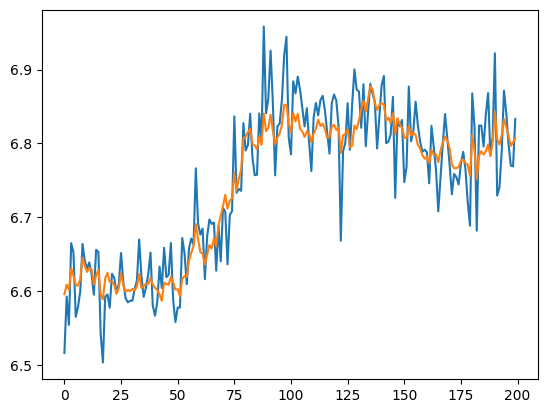

In [23]:
scale=1
ind = range(22550,22750)
#plt.plot(range(len(ind)),data[:200,10]-test_data[:200,10].numpy())
plt.plot(range(len(ind)),test_data[ind,50].cpu().numpy()/test_data[ind,4].cpu().numpy())
#plt.plot(range(len(ind)),(test_data[2900:3100,40].cpu().numpy()*scale-data[2900:3100,40])/scale)
plt.plot(range(len(ind)),(test_data[ind,50].cpu().numpy()-data[ind,50])/(test_data[ind,4].cpu().numpy()-data[ind,4]))
plt.show()

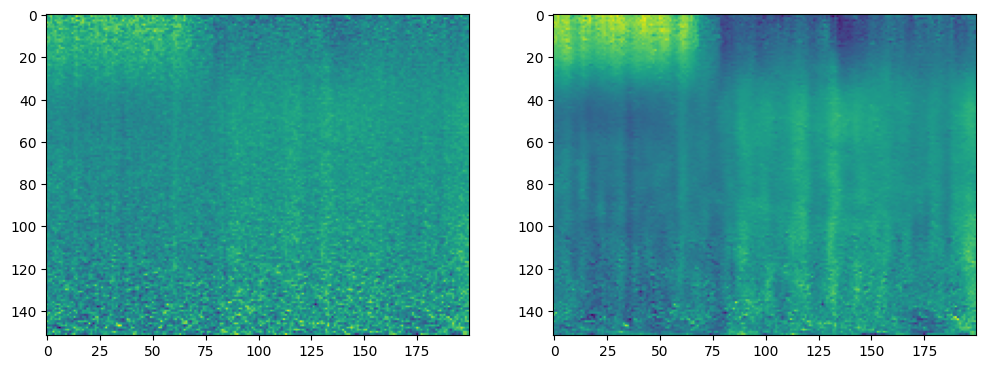

In [24]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(np.apply_along_axis(lambda x: x/np.mean(x),0,test_data[ind,:].cpu().numpy()).T)
axs[1].imshow(np.apply_along_axis(lambda x: x/np.mean(x),0,test_data[ind,:].cpu().numpy()-data[ind,:]).T)
plt.show()

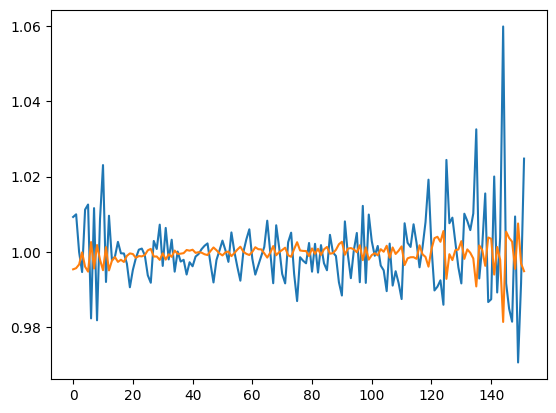

In [ ]:
plt.plot(range(152),test_data[ind[0]+12,:].cpu().numpy()/test_data[ind[0]+10,:].cpu().numpy())
plt.plot(range(152),(test_data[ind[0]+12,:].cpu().numpy()-data[ind[0]+12,:])/(test_data[ind[0]+10,:].cpu().numpy()-data[ind[0]+10,:]))
plt.show()

In [36]:
#scale=1
with h5py.File('/content/drive/MyDrive/Projects/Data/DeepDenoise/data_denoised.h5', 'w') as f:
  #f['data'] = (test_data[:,160:312].numpy()*scale-data)/scale
  f['data'] = (test_data.numpy()*scale-data)/scale

In [34]:
#optimize scaling factor
std_sample = []
for sc in np.arange(0.5,1.5,0.05):
  data_seg = data_net[50,:,:,:].unsqueeze(0)*sc
  data_sample = data_seg.detach().numpy()-net(data_seg).detach().numpy()
  data_sample = np.apply_along_axis(lambda x: x/np.mean(x),0,np.squeeze(data_sample))
  std_sample.append(np.std(data_sample))

scale = np.arange(0.5,1.5,0.05)[np.argmin(std_sample)]

0.7000000000000002


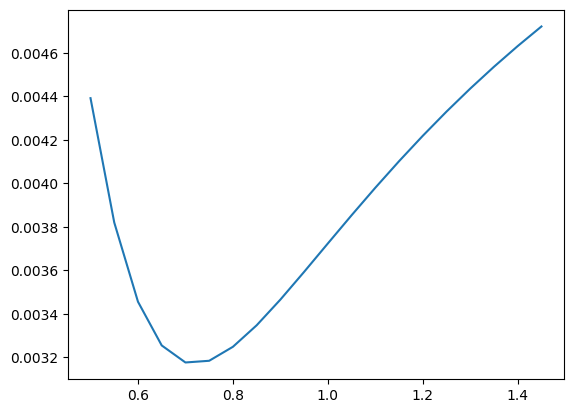

In [35]:
print(scale)
plt.plot(np.arange(0.5,1.5,0.05),std_sample)
plt.show()

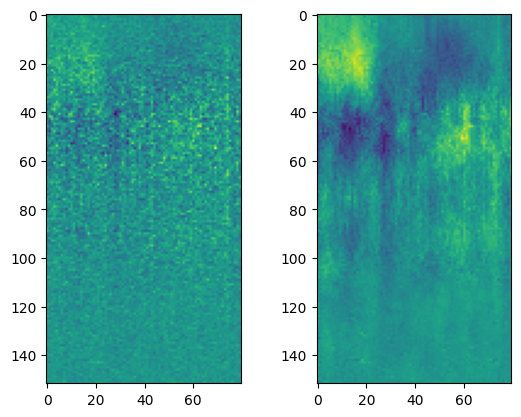

In [33]:
#scale=1
data_seg = data_net[156,:,:,:].unsqueeze(0)*scale
#data_norm = data_seg-torch.mean(data_seg,dim=0)
#print(type(data_seg))
data_sample = data_seg.detach().numpy()-net(data_seg).detach().numpy()

fig, axs = plt.subplots(1,2)
axs[0].imshow(np.apply_along_axis(lambda x: x-np.mean(x),0,np.squeeze(data_seg))[:80,:].T)
axs[1].imshow(np.apply_along_axis(lambda x: x-np.mean(x),0,np.squeeze(data_sample))[:80,:].T)
plt.show()

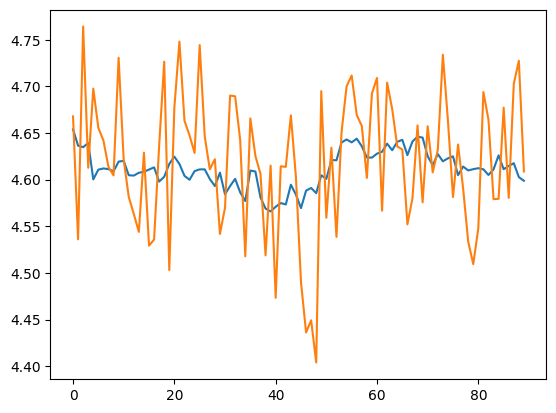

In [ ]:
plt.plot(range(90),np.squeeze(data_sample)[:90,42]/np.squeeze(data_sample)[:90,10])
plt.plot(range(90),np.squeeze(data_seg)[:90,42]/np.squeeze(data_seg)[:90,10])
plt.show()


In [ ]:
data_seg = test_data[500:600,160:312]
data_seg = data_seg-net(data_seg.view((1,1,100,152))).detach().numpy()
data_norm = data_seg-torch.mean(data_seg,dim=0)

plt.imshow(data_norm.T)
plt.show()

RuntimeError: ignored

In [ ]:
data_seg = test_data[500:600,160:332]

plt.imshow(data_norm)
plt.show()